# 📚  Exercise Histopathology Foundation Model

Exercise adapted from Charlotte Bunne, EPFL

This exercise needs to be run on a Modal notebook. 


- [Subtask 1.0: Get familiar with Histopathology images](#Subtask-1.0:-Get-familiar-with-Histopathology-images)
- [Subtask 1.1: Linear Probing based on FM embeddings](#task-11-linear-probing-based-on-fm-embeddings)
- [Subtask 1.2: Tissue-level classification](#task-12-tissue-level-classification)
- [Subtask 1.3: Whole-slide image analysis](#task-13-whole-slide-image-analysis)

# Computation: 

I uploaded this notebook to modal and ran it on an A10 GPU with 4 CPU cores and 16GB of RAM

## Task 1: Histopathology Foundation Models

In this task we are taking a look at one prominent area of Vision Foundation Models trained using DINOv2: Histopathology.
Since there is a bunch of different clincal "downstream" tasks on which one can possibly utilize large FMs, there is a variety of benchmarks available to, e.g., predict tumor (sub-)types, gene expressions within areas of the tissue, interesting Regions of Interest (ROIs). An overview of a few different and commonly used pathology models can be found here: https://birkhoffkiki.github.io/PathBench/. For this exercise, we are using the Phikon2 model.

In [1]:
%uv pip install torch transformers datasets Pillow umap-learn
%uv pip install s3fs tiffile imagecodecs zarr scikit-image
%uv pip install matplotlib seaborn

Using Python 3.12.6 environment at: /usr/local
Resolved 72 packages in 71ms
Uninstalled 1 package in 1ms
Installed 1 package in 81ms
 - fsspec==2026.1.0
 + fsspec==2025.10.0
Note: you may need to restart the kernel to use updated packages.
Using Python 3.12.6 environment at: /usr/local
Resolved 36 packages in 48ms
Uninstalled 1 package in 2ms
Installed 1 package in 85ms
 - fsspec==2025.10.0
 + fsspec==2026.1.0
Note: you may need to restart the kernel to use updated packages.
Using Python 3.12.6 environment at: /usr/local
Audited 2 packages in 6ms
Note: you may need to restart the kernel to use updated packages.


In [2]:
try:
    from umap.umap_ import UMAP
except ImportError:
    from umap import UMAP

In [3]:
from PIL import Image
import torch
from transformers import AutoImageProcessor, AutoModel
import matplotlib.pyplot as plt
from datasets import load_dataset
from tqdm import tqdm
import numpy as np

In [4]:
# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

<a id="task1.0"></a>

### Task 1.0: Getting familiar with Histopathology images.

**Histopathology background:** <br>
Histopathology is the microscopic examination of tissue samples to study the manifestations of disease. It is widely used in medical diagnosis to identify abnormalities such as cancer, inflammation, and infections. <br>
One of the fundamental staining techniques in histopathology is Hematoxylin and Eosin (H&E) staining. This method uses two dyes: hematoxylin and eosin. Hematoxylin stains cell nuclei a purplish-blue color, highlighting DNA and nuclear structures, while eosin stains the cytoplasm and extracellular matrix various shades of pink or red. The color contrast provided by H&E staining allows pathologists to easily differentiate cellular components and assess tissue architecture and pathological changes effectively. <br>
H&E staining is valued for its simplicity, cost-effectiveness, and ability to provide detailed visualization of tissue structure, making it the gold standard in histopathology laboratories globally. <br>

In the following, we are taking a look at H&E stains of lung tissue samples. More precisly, we are trying to label the lung cancer type of the H&E stains to distinguish between Lung adenocarcinoma (LUAD) and Lung squamous cell carcinoma (LUSC). 


In [5]:
# if you get an error here, try setting streaming=False. 
# This will download the dataset locally in advance.
ds_train = load_dataset("dakomura/tcga-ut", "internal", split="train", streaming=True) 

ds_train = ds_train.filter(lambda sample: "Lung" in sample["json"]["label"])

ds_test = load_dataset("dakomura/tcga-ut", "internal", split="test", streaming=True)
ds_test = ds_test.filter(lambda sample: "Lung" in sample["json"]["label"])

README.md: 0.00B [00:00, ?B/s]

Resolving data files:   0%|          | 0/39 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/39 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/39 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/39 [00:00<?, ?it/s]

In [6]:
# Load phikon-v2
processor = AutoImageProcessor.from_pretrained("owkin/phikon-v2", use_fast=True)
model = AutoModel.from_pretrained("owkin/phikon-v2")
model.eval()
model.to(device)

Fetching 1 files:   0%|          | 0/1 [00:00<?, ?it/s]

preprocessor_config.json:   0%|          | 0.00/750 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/1.21G [00:00<?, ?B/s]

Dinov2Model(
  (embeddings): Dinov2Embeddings(
    (patch_embeddings): Dinov2PatchEmbeddings(
      (projection): Conv2d(3, 1024, kernel_size=(16, 16), stride=(16, 16))
    )
    (dropout): Dropout(p=0.0, inplace=False)
  )
  (encoder): Dinov2Encoder(
    (layer): ModuleList(
      (0-23): 24 x Dinov2Layer(
        (norm1): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
        (attention): Dinov2Attention(
          (attention): Dinov2SelfAttention(
            (query): Linear(in_features=1024, out_features=1024, bias=True)
            (key): Linear(in_features=1024, out_features=1024, bias=True)
            (value): Linear(in_features=1024, out_features=1024, bias=True)
          )
          (output): Dinov2SelfOutput(
            (dense): Linear(in_features=1024, out_features=1024, bias=True)
            (dropout): Dropout(p=0.0, inplace=False)
          )
        )
        (layer_scale1): Dinov2LayerScale()
        (drop_path): Identity()
        (norm2): LayerNorm((1024,),

In [7]:
def load_and_process_image(sample):
    image_bytes = sample["jpg"]
    # image = Image.open(io.BytesIO(image_bytes))
    image = image_bytes
    return {
        "image": image,
        "label": sample["json"]["label"],
        "patient_id": sample["__key__"][:12] # TCGA-XX-XXXX
    }

ds_train_processed = ds_train.map(load_and_process_image, remove_columns=["jpg", "json", "__key__", "__url__"])
ds_test_processed = ds_test.map(load_and_process_image, remove_columns=["jpg", "json", "__key__", "__url__"])


**Exercise 1**: Visualize some of the H&E samples of the dataset and display corresponding the labels and patient ids.

- Are histopathology images different from common images, e.g., as seen in the ImageNet-1k dataset?
- If so, what implications would this have...
    - to data distributions?
    - to general pre-trained FMs for RGB images?
    - to data pre-processing?
    - ...


Visualize some of the crops, print the label as well as as the patient id of the crop.

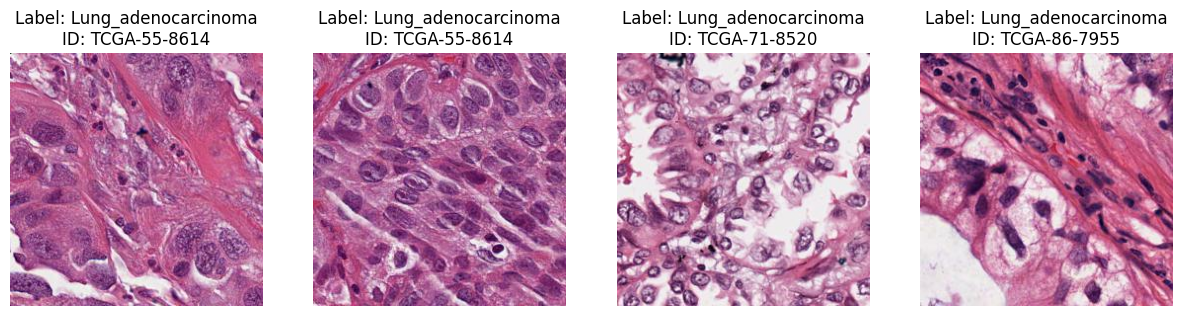

In [9]:
iter_ds = iter(ds_train_processed)

fig, axes = plt.subplots(1, 4, figsize=(15, 5))
for i in range(4):
    try:
        sample = next(iter_ds)
        axes[i].imshow(sample['image'])
        axes[i].set_title(f"Label: {sample['label']}\nID: {sample['patient_id']}")
        axes[i].axis('off')
    except StopIteration:
        pass
plt.show()

<a name="task1.1"></a>

### Task 1.1: Linear Probing based on FM embeddings

**Exercise 2**: 
1. Embed the training crops, store the patient ids as well as the labels. 
2. Visualize the embeddings using a UMAP
3. Fit a Logistic Regression (LR) model on the training set
4. Embed the testset crops, and evaluate the LR using accuracy and F1-score.


In [11]:
ds_train_processed = ds_train_processed.with_format("torch")
ds_test_processed = ds_test_processed.with_format("torch")

BATCH_SIZE = 32
EMBEDDING_SIZE = 1024
NR_BATCHES = 100

dl_train = torch.utils.data.DataLoader(
    ds_train_processed,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=8,
)

In [15]:
embeddings = torch.zeros((BATCH_SIZE * NR_BATCHES, EMBEDDING_SIZE))
labels = []
patient_ids = []

with torch.inference_mode():
    with torch.autocast(device.type, torch.bfloat16):
        for i, batch in enumerate(tqdm(dl_train, total=NR_BATCHES)):
            inputs = processor(batch["image"], return_tensors="pt").to(device)
            outputs = model(**inputs)
            # Phikon-v2 Cls token is at index 0
            batch_embeddings = outputs.last_hidden_state[:, 0, :].cpu()
            embeddings[i * BATCH_SIZE : (i + 1) * BATCH_SIZE] = batch_embeddings
            labels.extend(batch["label"])
            patient_ids.extend(batch["patient_id"])

            if i == (NR_BATCHES - 1):
              break

 99%|████████████████████████████████████████████████████████████████████████▎| 99/100 [00:17<00:00,  5.52it/s]


**Exercise 3**:

Now that we have encoded our lung histopathology crops, visualize them in a UMAP.
Using the same umap embedding, color the plot once by patient ids and once by tumor type.

Create a second UMAP in which you visualize the embedded crops from only four patients, e.g. ['TCGA-33-4582', 'TCGA-55-8614', 'TCGA-77-8138', 'TCGA-71-8520'].

- What do you see in the UMAPs?
    - Are there overlapping classes?
    - If so why, if not why not?
    - How nicely are the cancer types clustering?
    - Do we also see clustering in the patients? Why could this be?

/usr/local/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


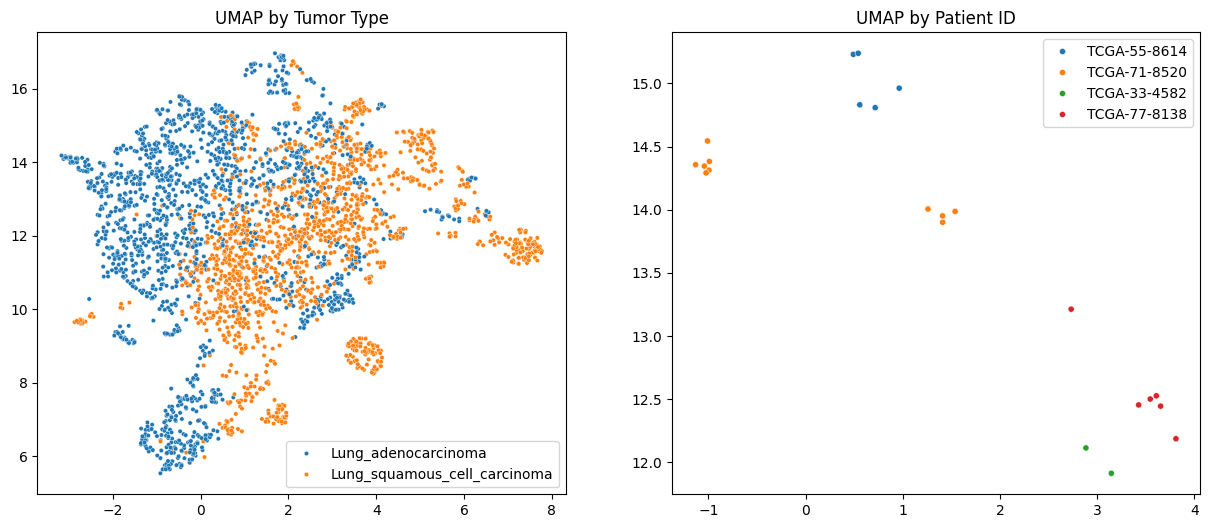

In [16]:
import seaborn as sns
labels = np.array(labels)
patient_ids = np.array(patient_ids)

reducer = UMAP(n_neighbors=30, min_dist=0.3, n_components=2, random_state=42)
embedding_2d = reducer.fit_transform(embeddings)

fig, ax = plt.subplots(1, 2, figsize=(15, 6))
sns.scatterplot(x=embedding_2d[:, 0], y=embedding_2d[:, 1], hue=labels, ax=ax[0], s=10)
ax[0].set_title("UMAP by Tumor Type")

selected_patients = ['TCGA-33-4582', 'TCGA-55-8614', 'TCGA-77-8138', 'TCGA-71-8520']
mask = np.isin(patient_ids, selected_patients)
sns.scatterplot(x=embedding_2d[mask, 0], y=embedding_2d[mask, 1], hue=patient_ids[mask], ax=ax[1], s=20)
ax[1].set_title("UMAP by Patient ID")
plt.show()

Now, we can do some logistic regression based on the FM embeddings to differentiate between Lung Adenocarcinoma (LUAD) and Lung Squamous Cell Carcinoma ( LUSC).

First, train a Logistic Regression classifier, afterwards embed the first 100 batches with a batch size of 32 of the test dataset defined above and calculate the accuracy as well as the f1-score on it. Additionally, save the patient ids for the next task.

In [17]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(max_iter=1000, random_state=42)
clf.fit(embeddings, labels)
print("Logistic Regression trained.")

Logistic Regression trained.


In [18]:
dl_test = torch.utils.data.DataLoader(
    ds_test_processed,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=8,
)

In [19]:
embeddings_test = torch.zeros((BATCH_SIZE * NR_BATCHES, EMBEDDING_SIZE))
labels_test = []
patient_ids_test = []

with torch.inference_mode():
    with torch.autocast(device.type, torch.bfloat16):
        for i, batch in enumerate(tqdm(dl_test, total=NR_BATCHES)):
            inputs = processor(batch["image"], return_tensors="pt").to(device)
            outputs = model(**inputs)
            batch_embeddings = outputs.last_hidden_state[:, 0, :].cpu()
            embeddings_test[i * BATCH_SIZE : (i + 1) * BATCH_SIZE] = batch_embeddings
            labels_test.extend(batch["label"])
            patient_ids_test.extend(batch["patient_id"])

            if i == (NR_BATCHES - 1):
              break

  8%|█████▉                                                                    | 8/100 [00:12<02:00,  1.31s/it]'(ReadTimeoutError("HTTPSConnectionPool(host='cas-bridge.xethub.hf.co', port=443): Read timed out. (read timeout=10)"), '(Request ID: ad09ed85-3cb7-4a9c-8386-11a1770955a0)')' thrown while requesting GET https://huggingface.co/datasets/dakomura/tcga-ut/resolve/bac8024327f498a6710c030aff240637764af0dc/data/dataset_internal_test_part002.tar
Retrying in 1s [Retry 1/5].
 48%|███████████████████████████████████                                      | 48/100 [01:03<00:54,  1.05s/it]HTTP Error 502 thrown while requesting GET https://huggingface.co/datasets/dakomura/tcga-ut/resolve/bac8024327f498a6710c030aff240637764af0dc/data/dataset_internal_test_part007.tar
Retrying in 1s [Retry 1/5].
HTTP Error 502 thrown while requesting GET https://huggingface.co/datasets/dakomura/tcga-ut/resolve/bac8024327f498a6710c030aff240637764af0dc/data/dataset_internal_test_part000.tar
Retrying in 1s [Retry 

In [20]:
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

lr_predictions = clf.predict(embeddings_test)

acc = accuracy_score(labels_test, lr_predictions)
f1 = f1_score(labels_test, lr_predictions, average='weighted')
cm = confusion_matrix(labels_test, lr_predictions)

print(f"Accuracy: {acc:.4f}")
print(f"F1 Score: {f1:.4f}")
print("Confusion Matrix:")
print(cm)

Accuracy: 0.8925
F1 Score: 0.8925
Confusion Matrix:
[[1461  143]
 [ 201 1395]]


<a id="task1.2"></a>


### Task 1.2: Tissue-level classification

Until now, we did everything on a crop level (256x256 pixels) extracted from a larger pathology whole slide that often spans more than 10,000 x 10,000 pixels.
As we are interested in a tissue-level and not crop level task, it would make more sense to derive predictions on a patient level.

We implement majority voting as a simple baseline to derive tissue-level prediction from the logisitic regression based test-set predictions





In [21]:
import pandas as pd

df = pd.DataFrame({"pid": patient_ids_test, "prediction": lr_predictions, "label": labels_test})
df_majority_voting = df.groupby("pid").agg({"prediction":pd.Series.mode, "label":"first"})

predictions_tissue = df_majority_voting["prediction"].values
labels_tissue = df_majority_voting["label"].values

# resolve ties
predictions_tissue = [p[0] if isinstance(p, np.ndarray) else p for p in predictions_tissue]

Now calculate tissue-level accuracies and f1-score.
- Would you expect improving performances? Why?

In [22]:
from sklearn.metrics import accuracy_score, f1_score
acc_tissue = accuracy_score(labels_tissue, predictions_tissue)
f1_tissue = f1_score(labels_tissue, predictions_tissue, average='weighted')
print(f"Tissue-Level Accuracy: {acc_tissue:.4f}")
print(f"Tissue-Level F1 Score: {f1_tissue:.4f}")

Tissue-Level Accuracy: 0.9318
Tissue-Level F1 Score: 0.9317


<a id="task1.3"></a>


### Task 1.3: Whole-slide image analysis

So far we have taken a look at tissue-level downstream tasks where we were interested in global labels. We can also take a look at more local labels in a whole slide image (WSI).

In this task, we are using a WSI originating from a colorectal cancer (CRC) patient. A visualization of the WSI can be found [here](https://www.cycif.org/data/orion-crc/P37_S38-CRC10#s=0#w=0#g=5#m=-1#a=-100_-100#v=0.4618_0.8898_0.6185#o=-100_-100_1_1#p=Q).



In [23]:
import s3fs
import os

fs = s3fs.S3FileSystem(anon=True)
s3_path = 'lin-2023-orion-crc/data/CRC10/18459_LSP10452_US_SCAN_OR_001__091355-registered.ome.tif'

# Local filename to save the image
local_filename = 'crc10_he_wsi.ome.tif'

if not os.path.exists(local_filename):
    # Download the file from S3 to local filesystem
    fs.get(s3_path, local_filename)

print(f'Downloaded {local_filename}')

Downloaded crc10_he_wsi.ome.tif


Loading the image. To save some RAM and compute time, we only take a look at a 10,080 x 10,080 subpart of the WSI.

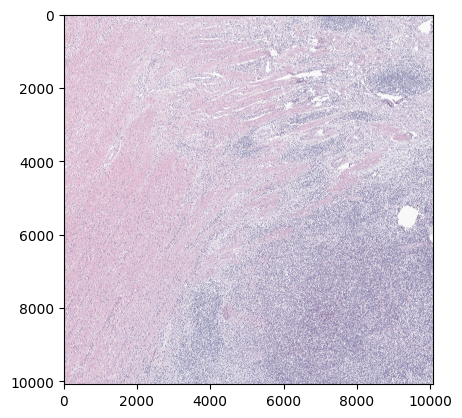

In [24]:
import tifffile

region = tifffile.imread(local_filename)
region = region[15000:25080, 5000:15080]
plt.imshow(region)

Now, embed the tissue by iterating over the image using a crop size of 224x224 without overlap, store the cls tokens and the local patch tokens of each of the crops.

Afterwards, take the top left and the bottom right cls embedding as well as the mean of local patch embeddings of the top left as well as bottom right crop. These will serve as "prototypes". Cacluate the cosine similarities between all cls tokens and the cls-based prototypes and the patches and the patch-based prototypes, respectively.

Hint: the patch size of the Phikon2 model is 16x16.

**Exercise 4**:
1. Implement the sliding window embedding 
2. Calculate cosine similarities of a prototype of the image and all other embeddings
3. Visualize the cosine similarities

In [25]:
embeddings_cls = torch.zeros((45,45, EMBEDDING_SIZE))
embeddings_ps = torch.zeros((630,630, EMBEDDING_SIZE))

region_x, region_y = region.shape[:2]

with torch.inference_mode():
    with torch.autocast(device.type, torch.bfloat16):
        for x in tqdm(range(45)):
            for y in range(45):
                # Extract 224x224 crop
                crop = region[x*224:(x+1)*224, y*224:(y+1)*224]
                inputs = processor(crop, return_tensors="pt").to(device)
                outputs = model(**inputs)
                
                # CLS token
                cls_token = outputs.last_hidden_state[:, 0, :].cpu()
                embeddings_cls[x, y] = cls_token
                
                # Patch tokens (reshaping)
                patch_tokens = outputs.last_hidden_state[:, 1:, :].cpu()
                patch_tokens = patch_tokens.reshape((14, 14, EMBEDDING_SIZE))
                embeddings_ps[x*14:(x+1)*14, y*14:(y+1)*14] = patch_tokens

100%|██████████████████████████████████████████████████████████████████████████| 45/45 [04:09<00:00,  5.54s/it]


In [28]:
import torch
import torch.nn.functional as F

# --- Top Left (00) ---
# For the cls tokens
cls_00 = embeddings_cls[0, 0]  # shape: (EMBEDDING_SIZE,)
cls_00 = cls_00.unsqueeze(0)  # shape: (1, EMBEDDING_SIZE)

vectors_all_cls = embeddings_cls.view(-1, embeddings_cls.shape[2])
cosine_sim_cls_00 = F.cosine_similarity(cls_00, vectors_all_cls, dim=1)
cosine_sim_cls_00 = cosine_sim_cls_00.reshape(embeddings_cls.shape[:2])

# For the ps tokens
ps_00 = torch.mean(embeddings_ps[:14, :14], dim=(0,1))
ps_00 = ps_00.unsqueeze(0)  # shape: (1, EMBEDDING_SIZE)

vectors_all_ps = embeddings_ps.view(-1, embeddings_ps.shape[2])
cosine_sim_ps_00 = F.cosine_similarity(ps_00, vectors_all_ps, dim=1)
cosine_sim_ps_00 = cosine_sim_ps_00.reshape(embeddings_ps.shape[:2])

# --- Bottom Right (nn) ---
# For the cls tokens
cls_nn = embeddings_cls[-1, -1]
cls_nn = cls_nn.unsqueeze(0)
cosine_sim_cls_nn = F.cosine_similarity(cls_nn, vectors_all_cls, dim=1)
cosine_sim_cls_nn = cosine_sim_cls_nn.reshape(embeddings_cls.shape[:2])

# For the ps tokens
ps_nn = torch.mean(embeddings_ps[-14:, -14:], dim=(0,1))
ps_nn = ps_nn.unsqueeze(0)
cosine_sim_ps_nn = F.cosine_similarity(ps_nn, vectors_all_ps, dim=1)
cosine_sim_ps_nn = cosine_sim_ps_nn.reshape(embeddings_ps.shape[:2])

Visualize the cosine similarities on top of the image between the selected prototypes and all other embeddings (once for the cls tokens, once for the patch tokens).

- What do you observe?
- What could this be useful for in a clinical setting?

/tmp/ipykernel_536/744595007.py:5: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  cosine_sim_cls_00_resized = resize(np.array(cosine_sim_cls_00), (region_x, region_y))
/tmp/ipykernel_536/744595007.py:6: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  cosine_sim_cls_nn_resized = resize(np.array(cosine_sim_cls_nn), (region_x, region_y))
/tmp/ipykernel_536/744595007.py:8: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  cosine_sim_ps_00_resized = resize(np.array(cosine_sim_ps_00), (region_x, region_y))
/tmp/ipykernel_536/744595007.py:9: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy

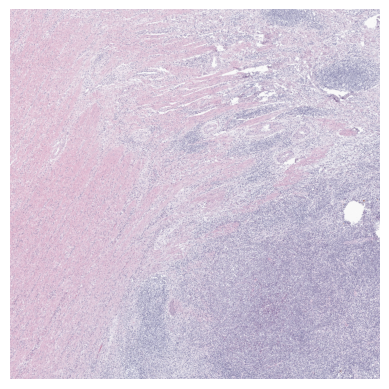

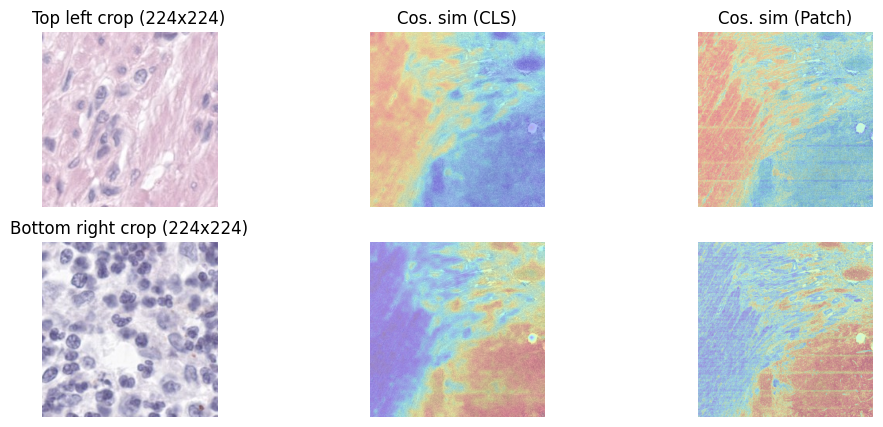

In [29]:
from skimage.transform import resize



cosine_sim_cls_00_resized = resize(np.array(cosine_sim_cls_00), (region_x, region_y))
cosine_sim_cls_nn_resized = resize(np.array(cosine_sim_cls_nn), (region_x, region_y))

cosine_sim_ps_00_resized = resize(np.array(cosine_sim_ps_00), (region_x, region_y))
cosine_sim_ps_nn_resized = resize(np.array(cosine_sim_ps_nn), (region_x, region_y))


plt.imshow(region[::10, ::10])
plt.axis('off')
plt.show()

fig, axs = plt.subplots(2,3, figsize=(12, 5))
axs = axs.flatten()
axs[0].imshow(region[:224, :224])
axs[0].set_title("Top left crop (224x224)")
axs[1].imshow(region[::10, ::10])
axs[1].imshow(cosine_sim_cls_00_resized[::10, ::10], alpha=0.3, cmap="jet")
axs[2].imshow(region[::10, ::10])
axs[2].imshow(cosine_sim_ps_00_resized[::10, ::10], alpha=0.3, cmap="jet")
axs[3].imshow(region[-224:, -224:])
axs[3].set_title("Bottom right crop (224x224)")
axs[4].imshow(region[::10, ::10])
axs[4].imshow(cosine_sim_cls_nn_resized[::10, ::10], alpha=0.3, cmap="jet")
axs[5].imshow(region[::10, ::10])
axs[5].imshow(cosine_sim_ps_nn_resized[::10, ::10], alpha=0.3, cmap="jet")

axs[1].set_title("Cos. sim (CLS)")
axs[2].set_title("Cos. sim (Patch)")

for ax in axs:
    ax.axis('off')